# Plan-and-Execute

이 노트북은 "계획 및 실행(plan-and-execute)" 스타일의 에이전트를 만드는 방법을 보여줍니다. 이는 [Plan-and-Solve](https://arxiv.org/abs/2305.04091) 논문과 [Baby-AGI](https://github.com/yoheinakajima/babyagi) 프로젝트에서 큰 영감을 받았습니다.

핵심 아이디어는 먼저 여러 단계의 계획을 세운 다음, 그 계획을 하나씩 실행하는 것입니다. 특정 작업을 완료한 후에는 계획을 다시 검토하고 적절하게 수정할 수 있습니다.

일반적인 계산 그래프는 다음과 같습니다:

<img src="./img/plan-and-execute.png" alt="plan-and-execute diagram" width="640"/>

이는 보통의 [ReAct](https://arxiv.org/abs/2210.03629) 스타일 에이전트와 비교됩니다. ReAct 스타일 에이전트는 한 번에 한 단계씩 생각합니다. "계획 및 실행" 스타일 에이전트의 장점은 다음과 같습니다:

1. 명시적인 장기 계획 수립 (이는 매우 강력한 LLM에서도 어려움을 겪을 수 있습니다)
2. 실행 단계에서는 더 작고 약한 모델을 사용할 수 있으며, 계획 단계에서는 더 크고 나은 모델을 사용

다음의 단계별 설명은 LangGraph에서 이를 구현하는 방법을 보여줍니다.

## Setup

In [ ]:
!pip install --quiet -U langgraph langchain-community langchain-openai tavily-python

In [ ]:
import getpass
import os


def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")


_set_env("OPENAI_API_KEY")
_set_env("TAVILY_API_KEY")

In [1]:
#gemini setting
import google.generativeai as genai

#os_key Setting

from dotenv import load_dotenv
import os
# .env 파일 로드(api key load) 
#GOOGLE_API_KEY 
#LANGCHAIN_API_KEY 
#TAVILY_API_KEY 
#HUGGINGFACEHUB_API_TOKEN 
#COHERE_API_KEY 

load_dotenv()

# GOOGLE_API_KEY 환경 변수 값 가져오기
google_api_key = os.getenv('GOOGLE_API_KEY')

# genai.configure로 GOOGLE API KEY Setting하기기
genai.configure(api_key=google_api_key)

## 도구 정의하기

먼저 우리가 사용하고자 하는 도구를 정의하겠습니다. 이 간단한 예시에서는 Tavily를 통해 내장된 검색 도구를 사용할 것입니다. 하지만 자신만의 도구를 만드는 것도 매우 간단합니다. 여기에 대한 자세한 내용은 [여기](https://python.langchain.com/v0.2/docs/how_to/custom_tools)에서 확인하세요.

In [2]:
from langchain_community.tools.tavily_search import TavilySearchResults
tools = [TavilySearchResults(max_results=3)]

## 실행 에이전트 정의하기

이제 우리가 사용하고자 하는 실행 에이전트를 만들어 작업을 수행할 것입니다. 이 예시에서는 각 작업에 대해 동일한 실행 에이전트를 사용할 예정이지만, 반드시 이렇게 해야 하는 것은 아닙니다.

In [65]:
from langchain import hub
from langchain_openai import ChatOpenAI

from langgraph.prebuilt import create_react_agent

# Get the prompt to use - you can modify this!
prompt = hub.pull("wfh/react-agent-executor")
prompt.pretty_print()


================================ System Message ================================

You are a helpful assistant.

============================= Messages Placeholder =============================

{{messages}}


In [3]:
#gemini
from langchain import hub
#gemini chatbot setting
from langchain_google_genai import ChatGoogleGenerativeAI


from langgraph.prebuilt import create_react_agent

# Get the prompt to use - you can modify this!
prompt = hub.pull("wfh/react-agent-executor")
prompt.pretty_print()

================================ System Message ================================

You are a helpful assistant.

============================= Messages Placeholder =============================

{{messages}}


### System prompt 패치하기

In [10]:
#prompt 내용 확인하기
type(prompt)

langchain_core.prompts.chat.ChatPromptTemplate

In [13]:
prompt

ChatPromptTemplate(input_variables=['{messages}'], input_types={'{messages}': list[typing.Annotated[typing.Union[typing.Annotated[langchain_core.messages.ai.AIMessage, Tag(tag='ai')], typing.Annotated[langchain_core.messages.human.HumanMessage, Tag(tag='human')], typing.Annotated[langchain_core.messages.chat.ChatMessage, Tag(tag='chat')], typing.Annotated[langchain_core.messages.system.SystemMessage, Tag(tag='system')], typing.Annotated[langchain_core.messages.function.FunctionMessage, Tag(tag='function')], typing.Annotated[langchain_core.messages.tool.ToolMessage, Tag(tag='tool')], typing.Annotated[langchain_core.messages.ai.AIMessageChunk, Tag(tag='AIMessageChunk')], typing.Annotated[langchain_core.messages.human.HumanMessageChunk, Tag(tag='HumanMessageChunk')], typing.Annotated[langchain_core.messages.chat.ChatMessageChunk, Tag(tag='ChatMessageChunk')], typing.Annotated[langchain_core.messages.system.SystemMessageChunk, Tag(tag='SystemMessageChunk')], typing.Annotated[langchain_core

In [20]:
# 파이썬에서 객체의 모든 속성 확인 방법
class Example:
    def __init__(self):
        self.attribute = "Hello, world!"

# 객체 생성
obj = Example()

# 객체의 모든 속성을 딕셔너리 형태로 출력
print(obj.__dict__)

{'attribute': 'Hello, world!'}


In [18]:
prompt.__dict__

{'name': None,
 'input_variables': ['{messages}'],
 'optional_variables': [],
 'input_types': {'{messages}': list[typing.Annotated[typing.Union[typing.Annotated[langchain_core.messages.ai.AIMessage, Tag(tag='ai')], typing.Annotated[langchain_core.messages.human.HumanMessage, Tag(tag='human')], typing.Annotated[langchain_core.messages.chat.ChatMessage, Tag(tag='chat')], typing.Annotated[langchain_core.messages.system.SystemMessage, Tag(tag='system')], typing.Annotated[langchain_core.messages.function.FunctionMessage, Tag(tag='function')], typing.Annotated[langchain_core.messages.tool.ToolMessage, Tag(tag='tool')], typing.Annotated[langchain_core.messages.ai.AIMessageChunk, Tag(tag='AIMessageChunk')], typing.Annotated[langchain_core.messages.human.HumanMessageChunk, Tag(tag='HumanMessageChunk')], typing.Annotated[langchain_core.messages.chat.ChatMessageChunk, Tag(tag='ChatMessageChunk')], typing.Annotated[langchain_core.messages.system.SystemMessageChunk, Tag(tag='SystemMessageChunk')], 

In [27]:
print(prompt.messages)

[SystemMessagePromptTemplate(prompt=PromptTemplate(input_variables=[], input_types={}, partial_variables={}, template='너는 도움이 되는 AI 어시스턴트이다'), additional_kwargs={}), MessagesPlaceholder(variable_name='{messages}')]


In [28]:
type(prompt.messages)

list

In [29]:
len(prompt.messages)

2

In [30]:
prompt.messages[0]

SystemMessagePromptTemplate(prompt=PromptTemplate(input_variables=[], input_types={}, partial_variables={}, template='너는 도움이 되는 AI 어시스턴트이다'), additional_kwargs={})

In [31]:
type(prompt.messages[0])

langchain_core.prompts.chat.SystemMessagePromptTemplate

In [32]:
prompt.messages[0].__dict__

{'prompt': PromptTemplate(input_variables=[], input_types={}, partial_variables={}, template='너는 도움이 되는 AI 어시스턴트이다'),
 'additional_kwargs': {}}

In [35]:
prompt.messages[0].prompt

PromptTemplate(input_variables=[], input_types={}, partial_variables={}, template='너는 도움이 되는 AI 어시스턴트이다')

In [36]:
type(prompt.messages[0].prompt)

langchain_core.prompts.prompt.PromptTemplate

In [37]:
prompt.messages[0].prompt.__dict__

{'name': None,
 'input_variables': [],
 'optional_variables': [],
 'input_types': {},
 'output_parser': None,
 'partial_variables': {},
 'metadata': None,
 'tags': None,
 'template': '너는 도움이 되는 AI 어시스턴트이다',
 'template_format': 'f-string',
 'validate_template': False}

In [38]:
prompt.messages[0].prompt.template

'너는 도움이 되는 AI 어시스턴트이다'

In [4]:

prompt.messages[0].prompt.template = "너는 도움이 되는 AI 어시스턴트이다"

In [5]:
prompt.pretty_print()

================================ System Message ================================

너는 도움이 되는 AI 어시스턴트이다

============================= Messages Placeholder =============================

{{messages}}


In [6]:
# Choose the LLM that will drive the agent
llm = ChatOpenAI(model="gpt-4o")
agent_executor = create_react_agent(llm, tools, messages_modifier=prompt)

In [6]:
# Choose the LLM that will drive the agent(gemini)
llm = ChatGoogleGenerativeAI(model="gemini-2.0-flash-exp", temperature=0)
agent_executor = create_react_agent(llm, tools, messages_modifier=prompt)

C:\Users\choiw\AppData\Local\Temp\ipykernel_35156\2710740790.py:3: LangGraphDeprecationWarning: Parameter 'messages_modifier' in function 'create_react_agent' is deprecated as of version 0.1.9 and will be removed in version 0.3.0. Use 'state_modifier' parameter instead.
  agent_executor = create_react_agent(llm, tools, messages_modifier=prompt)
Key 'title' is not supported in schema, ignoring
Key 'title' is not supported in schema, ignoring


In [7]:
agent_executor.invoke({"messages": [("user", "나스닥 시장 분위기 알려줘")]})

{'messages': [HumanMessage(content='나스닥 시장 분위기 알려줘', id='9249aef0-8c4c-46f4-a8dc-a64579fa374f'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_y84Ghri2tski8p4ZtekAZGW1', 'function': {'arguments': '{"query":"current NASDAQ market sentiment"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 22, 'prompt_tokens': 99, 'total_tokens': 121}, 'model_name': 'gpt-4o', 'system_fingerprint': 'fp_3e7d703517', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-57feea9f-905d-4a58-95c7-575ef3be64c8-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'current NASDAQ market sentiment'}, 'id': 'call_y84Ghri2tski8p4ZtekAZGW1'}], usage_metadata={'input_tokens': 99, 'output_tokens': 22, 'total_tokens': 121}),
  ToolMessage(content='[{"url": "https://www.nasdaq.com/market-activity", "content": "Find the latest stock market trends and activity today. Compare key indexes, including Nasdaq

In [7]:
agent_executor.invoke({"messages": [("user", "나스닥 시장 분위기 알려줘")]})

{'messages': [HumanMessage(content='나스닥 시장 분위기 알려줘', additional_kwargs={}, response_metadata={}, id='09517568-f5ca-4f7f-8814-54f89f3d084c'),
  AIMessage(content='', additional_kwargs={'function_call': {'name': 'tavily_search_results_json', 'arguments': '{"query": "\\ub098\\uc2a4\\ub2e5 \\uc2dc\\uc7a5 \\ubd84\\uc704\\uae30"}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': [{'category': 'HARM_CATEGORY_HATE_SPEECH', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_DANGEROUS_CONTENT', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_HARASSMENT', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_SEXUALLY_EXPLICIT', 'probability': 'NEGLIGIBLE', 'blocked': False}]}, id='run-3c8e2fc2-a369-4d67-8be7-d0040cf67272-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': '나스닥 시장 분위기'}, 'id': '193f716d-0b0e-459f-9a64-3639a2b5

In [9]:
agent_executor.invoke({"messages": [("user", "나스닥의 최신 정보를 알려줘")]})

{'messages': [HumanMessage(content='나스닥의 최신 정보를 알려줘', additional_kwargs={}, response_metadata={}, id='f870c3f3-5050-4b3d-8db7-66b506ebc000'),
  AIMessage(content='', additional_kwargs={'function_call': {'name': 'tavily_search_results_json', 'arguments': '{"query": "\\ub098\\uc2a4\\ub2e5 \\ucd5c\\uc2e0 \\uc815\\ubcf4"}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': [{'category': 'HARM_CATEGORY_HATE_SPEECH', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_DANGEROUS_CONTENT', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_HARASSMENT', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_SEXUALLY_EXPLICIT', 'probability': 'NEGLIGIBLE', 'blocked': False}]}, id='run-b27f31bc-299f-4dcb-a4a3-7b992430ce16-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': '나스닥 최신 정보'}, 'id': '29c950a3-c6d9-4f43-b482-8c6d2334240e', 

## State(상태) 정의하기

- 이제 이 에이전트가 추적할 상태를 정의하는 것부터 시작하겠습니다.
- 우선, 현재 계획을 추적해야 합니다. 이를 문자열 목록으로 나타내겠습니다.
- 다음으로, 이전에 실행된 단계를 추적해야 합니다. 이를 튜플 목록으로 나타내겠습니다 (이 튜플에는 단계와 그 결과가 포함됩니다).
- 마지막으로, 최종 응답과 원래 입력을 나타내는 상태도 필요합니다.

In [98]:
# 예시: ChatGoogleGenerativeAI 라이브러리에서 with_structured_output 사용하기

# 1. 라이브러리 임포트 (실제 모듈 이름은 설치된 패키지에 따라 달라질 수 있습니다)
from langchain_google_genai import ChatGoogleGenerativeAI

# 2. ChatGoogleGenerativeAI 인스턴스 생성
ai = ChatGoogleGenerativeAI(model="gemini-2.0-flash-exp", temperature=0)

json_schema = {
    "properties": {
        "field1": {"type": "string"},
        "field2": {"type": "integer"}
    },
    "required": ["field1", "field2"]
}

response = ai.generate_content(
    "Your prompt here",
    generation_config=GenerationConfig(
        response_mime_type="application/json",
        response_schema=json_schema
    )
)


content='## 오늘의 주요 뉴스 (2024년 5월 16일)\n\n**1. 제목: "尹대통령, \'채상병 특검법\' 재의요구…정국 급랭 불가피"**\n\n* **요약:** 윤석열 대통령이 \'채상병 특검법\'에 대해 재의요구권(거부권)을 행사했습니다. 이에 따라 여야 간 강경 대치가 예상되며, 정국 경색이 불가피할 것으로 보입니다. 더불어민주당은 강력 반발하며 재의결을 추진할 계획입니다.\n* **태그:** #채상병특검법 #윤석열대통령 #재의요구 #거부권 #정국경색 #여야대치 #더불어민주당\n\n**2. 제목: "美 CPI 둔화에도 금리인하 기대 후퇴…韓 경제 영향은?"**\n\n* **요약:** 미국의 4월 소비자물가지수(CPI) 상승률이 둔화되었지만, 여전히 높은 수준을 유지하며 연준의 금리 인하 기대감이 후퇴했습니다. 이는 한국 경제에도 영향을 미칠 수 있으며, 환율 변동성 확대 및 자본 유출 가능성에 대한 우려가 제기됩니다.\n* **태그:** #미국CPI #금리인하 #연준 #환율 #자본유출 #한국경제 #인플레이션\n\n**3. 제목: "전국 의대 교수들, \'주 1회 휴진\' 결정…의료 공백 우려 심화"**\n\n* **요약:** 전국 의과대학 교수들이 정부의 의대 증원 정책에 반발하며 주 1회 휴진을 결정했습니다. 이는 의료 공백을 더욱 심화시킬 수 있다는 우려를 낳고 있으며, 환자들의 불편과 불안감이 커지고 있습니다. 정부와 의료계 간의 갈등 해결이 시급한 상황입니다.\n* **태그:** #의대증원 #의대교수 #휴진 #의료공백 #의료계갈등 #정부정책 #환자불편\n\n**4. 제목: "카카오, \'먹통 사태\' 재발 방지 대책 발표…데이터센터 투자 확대"**\n\n* **요약:** 카카오가 지난해 발생한 \'먹통 사태\' 재발 방지를 위한 대책을 발표했습니다. 데이터센터 투자 확대, 재해 복구 시스템 강화, 서비스 안정성 개선 등을 주요 내용으로 담고 있습니다. 카카오의 서비스 안정성 확보 노력이 주목됩니다.\n* **태그:** #카카오 #먹통

In [39]:
import operator
from typing import Annotated, List, Tuple, TypedDict


class PlanExecute(TypedDict):
    input: str
    plan: List[str]
    past_steps: Annotated[List[Tuple], operator.add]
    response: str

## 계획 단계

이제 계획 단계를 만드는 것에 대해 생각해 봅시다. 이는 함수 호출을 사용하여 계획을 수립할 것입니다.

In [167]:
#open AI
from pydantic import BaseModel,Field

class Plan(BaseModel):
    """Plan to follow in future"""

    steps: List[str] = Field(
        description="다음의 단계들을 따라가세요. 정렬된 순서로 나열되어야 합니다."
    )

In [203]:
from langchain_core.pydantic_v1 import BaseModel, Field

class Plan(BaseModel):
    """
    이 함수는 주어진 작업에 대한 실행 계획을 생성합니다.
    
    Args:
    steps: list[str] = Field(
        description="실행해야 할 단계별 계획 목록",
        examples=[["사용자 요청 분석", "필요한 데이터 수집", "결과 종합"]]
    )
    """

    steps: list[str] = Field(
        description="실행해야 할 단계별 계획 목록",
        examples=[["사용자 요청 분석", "필요한 데이터 수집", "결과 종합"]]
    )

In [66]:
#openAI
from langchain_core.prompts import ChatPromptTemplate

planner_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            """주어진 목표에 대해, 간단한 단계별 계획을 세우세요. \
이 계획은 개별 작업을 포함해야 하며, 올바르게 실행하면 정확한 답을 도출할 수 있습니다. 불필요한 단계를 추가하지 마세요. \
최종 단계의 결과는 최종 답이어야 합니다. 각 단계가 필요한 모든 정보를 포함하도록 하고, 단계를 건너뛰지 마세요.""",
        ),
        ("placeholder", "{messages}"),
    ]
)
planner = planner_prompt | ChatOpenAI(
    model="gpt-4o", temperature=0
).with_structured_output(Plan)

OpenAIError: The api_key client option must be set either by passing api_key to the client or by setting the OPENAI_API_KEY environment variable

In [204]:
#Gemini
from langchain_core.prompts import ChatPromptTemplate

from langchain_google_genai import ChatGoogleGenerativeAI

model = ChatGoogleGenerativeAI(model="gemini-2.0-flash-exp", temperature=0)

#model = ChatGoogleGenerativeAI(
#    model="gemini-1.5-pro-latest",
#    temperature=0,
#    convert_system_message_to_human=True
#)

planner_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            """주어진 목표에 대해, 간단한 단계별 계획을 세우세요. \
이 계획은 개별 작업을 포함해야 하며, 올바르게 실행하면 정확한 답을 도출할 수 있습니다. 불필요한 단계를 추가하지 마세요. \
최종 단계의 결과는 최종 답이어야 합니다. 각 단계가 필요한 모든 정보를 포함하도록 하고, 단계를 건너뛰지 마세요.""",
        ),
        ("placeholder", "{messages}"),
    ]
)
planner = planner_prompt | model.with_structured_output(Plan)

Key 'title' is not supported in schema, ignoring
Key 'title' is not supported in schema, ignoring


In [207]:
reponse = planner.invoke(
    {
        "messages": ["24년 호주 오픈 우승자의 고향은 어디인가요?"]
    }
)

In [208]:
reponse

Plan(steps=['2024년 호주 오픈 우승자를 찾습니다.', '우승자의 고향을 찾습니다.', '우승자의 고향을 반환합니다.'])

#여기부터 시작

## 재계획 단계

이제, 이전 단계의 결과를 바탕으로 계획을 다시 세우는 단계를 만들어 봅시다.

In [13]:
from typing import Union


class Response(BaseModel):
    """Response to user."""

    response: str


class Act(BaseModel):
    """Action to perform."""

    action: Union[Response, Plan] = Field(
        description="수행할 작업. 사용자가 응답을 원하면 Response를 사용하세요. 답을 얻기 위해 도구를 추가로 사용해야 하면 Plan을 사용하세요."
    )


replanner_prompt = ChatPromptTemplate.from_template(
    """주어진 목표에 대해, 간단한 단계별 계획을 세우세요.
이 계획은 개별 작업을 포함해야 하며, 올바르게 실행하면 정확한 답을 도출할 수 있습니다. 불필요한 단계를 추가하지 마세요.
최종 단계의 결과는 최종 답이어야 합니다. 각 단계가 필요한 모든 정보를 포함하도록 하고, 단계를 건너뛰지 마세요.

당신의 목표는 다음과 같았습니다:
{input}

당신의 원래 계획은 다음과 같았습니다:
{plan}

현재까지 완료한 단계는 다음과 같습니다:
{past_steps}

계획을 적절히 업데이트하세요. 더 이상 필요한 단계가 없고 사용자에게 답변할 수 있다면 그렇게 응답하세요. 그렇지 않으면, 계획을 작성하세요. 아직 해야 할 단계만 계획에 추가하세요. 이미 완료된 단계를 계획의 일부로 반환하지 마세요."""
)


replanner = replanner_prompt | ChatOpenAI(
    model="gpt-4o", temperature=0
).with_structured_output(Act)

## Graph 만들기

In [14]:
from typing import Literal


async def execute_step(state: PlanExecute):
    plan = state["plan"]
    plan_str = "\n".join(f"{i+1}. {step}" for i, step in enumerate(plan))
    task = plan[0]
    task_formatted = f"""For the following plan:
{plan_str}\n\nYou are tasked with executing step {1}, {task}."""
    agent_response = await agent_executor.ainvoke(
        {"messages": [("user", task_formatted)]}
    )
    return {
        "past_steps": [task, agent_response["messages"][-1].content],
    }


async def plan_step(state: PlanExecute):
    plan = await planner.ainvoke({"messages": [("user", state["input"])]})
    return {"plan": plan.steps}


async def replan_step(state: PlanExecute):
    output = await replanner.ainvoke(state)
    if isinstance(output.action, Response):
        return {"response": output.action.response}
    else:
        return {"plan": output.action.steps}


def should_end(state: PlanExecute) -> Literal["agent", "__end__"]:
    if "response" in state and state["response"]:
        return "__end__"
    else:
        return "agent"

In [15]:
from langgraph.graph import StateGraph

workflow = StateGraph(PlanExecute)

# Add the plan node
workflow.add_node("planner", plan_step)

# Add the execution step
workflow.add_node("agent", execute_step)

# Add a replan node
workflow.add_node("replan", replan_step)

workflow.set_entry_point("planner")

# From plan we go to agent
workflow.add_edge("planner", "agent")

# From agent, we replan
workflow.add_edge("agent", "replan")

workflow.add_conditional_edges(
    "replan",
    # Next, we pass in the function that will determine which node is called next.
    should_end,
)

# Finally, we compile it!
# This compiles it into a LangChain Runnable,
# meaning you can use it as you would any other runnable
app = workflow.compile()

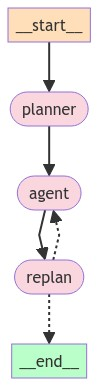

In [16]:
from IPython.display import Image, display

display(Image(app.get_graph(xray=True).draw_mermaid_png()))

In [17]:
config = {"recursion_limit": 50}
inputs = {"input": "2024년 호주 오픈 우승자의 고향에서 발생한 최근 사건은 무엇인가요?"}
async for event in app.astream(inputs, config=config):
    for k, v in event.items():
        if k != "__end__":
            print(v)

{'plan': ['2024년 호주 오픈 우승자가 누구인지 확인한다.', '해당 우승자의 고향이 어디인지 확인한다.', '우승자의 고향에서 발생한 최근 사건을 조사한다.']}
{'past_steps': ['2024년 호주 오픈 우승자가 누구인지 확인한다.', '2024년 호주 오픈 우승자는 이탈리아의 야닉 시너(Jannik Sinner)입니다.']}
{'plan': ['야닉 시너의 고향이 어디인지 확인한다.', '야닉 시너의 고향에서 발생한 최근 사건을 조사한다.']}
{'past_steps': ['야닉 시너의 고향이 어디인지 확인한다.', "Jannik Sinner's birthplace is Innichen, Italy."]}
{'plan': ['야닉 시너의 고향인 Innichen, Italy에서 발생한 최근 사건을 조사한다.']}
{'past_steps': ['야닉 시너의 고향인 Innichen, Italy에서 발생한 최근 사건을 조사한다.', '최근 Innichen, Italy에서 발생한 사건 중 하나는 프리스타일 스키 대회에서 Sixtine Cousin과 Terence Tchiknavorian이 깜짝 우승을 차지한 것입니다. 이 경기는 2023년 세계컵의 마지막 스키 크로스 레이스에서 이루어졌습니다. \n\n자세한 내용은 [Eurosport 기사](https://www.eurosport.com/freestyle-skiing/sixtine-cousin-and-terence-tchiknavorian-upset-odds-to-claim-innichen-victories-in-final-world-cup-r_sto9933529/story.shtml)에서 확인할 수 있습니다.']}
{'response': '최근 Innichen, Italy에서 발생한 사건 중 하나는 프리스타일 스키 대회에서 Sixtine Cousin과 Terence Tchiknavorian이 깜짝 우승을 차지한 것입니다. 이 경기는 2023년 세계컵의 마지막 스키 크로스 레이스에서 이루어졌습니